# PSF estimation

Myopic deconvolution algorithm from

Thibon, Louis, Ferréol Soulez, and Éric Thiébaut. _Fast automatic
myopic deconvolution of angiogram sequence_. In International
Symposium on Biomedical Imaging. Beijing, China, 2014. https://hal.archives-ouvertes.fr/hal-00914846.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage.io import imread
from skimage import img_as_float
from auto_metro.myopic_deconv import MODE_NAMES, zernike_tf, estimate_psf
from auto_metro.utils import _fft, _ifft, apodise
from scipy.optimize import minimize
from auto_metro.image_decorr import measure

mpl.rcParams['figure.figsize'] = (10, 7.5)


###  Definition of visualization functions

In [2]:

def get_tf(nx, ny, params, modes):
    """Compute the Zernike transfert function with parameters params
    
    """
    amps = [params[mode] for mode in modes]

    xx, yy = np.meshgrid(np.linspace(-1, 1, ny), np.linspace(-1, 1, nx))
    rho = (xx ** 2 + yy ** 2) ** 0.5
    phi = np.arctan2(yy, xx)
    
    tf = zernike_tf(
        rho,
        phi,
        params["resolution"],
        [1.0,]+amps,
        [(0, 0),] + modes
    )
    return tf

def show_results(image, params, modes, fft_window=20):
    """Displays the Maximum Likelyhood modelisation results
    
    """
    amps = [params[mode] for mode in modes]
    mode_names = [MODE_NAMES[mode].replace(' ', '\n') for mode in modes]

    nx, ny = image.shape
    tf = get_tf(nx, ny, params, modes)
    psf = _ifft(tf)

    fig, axes = plt.subplots(2, 2)
    axes[0, 0].imshow(image)
    axes[0, 0].set_title("input")

    axes[0, 1].imshow(np.abs(tf))
    axes[0, 1].set_title("wavefront")

    axes[1, 1].imshow(np.abs(psf)[
        nx//2-fft_window: nx//2+fft_window,
        ny//2-fft_window: ny//2+fft_window
    ])
    axes[1, 1].set_title("PSF")

    axes[1, 0].set_title("Zernike amplitudes")
    axes[1, 0].set_xlabel('Mode amplitude')
    axes[1, 0].barh(np.arange(len(amps)), amps)
    axes[1, 0].set_yticks(np.arange(len(amps)))
    axes[1, 0].set_yticklabels(mode_names);
    fig.tight_layout()
    return axes, fig

def print_params(params):
    """Pretty print of the estimated parameters
    """
    print(f'α : {params["alpha"]:.3e}')
    print(f'β : {params["beta"]:.3e}')
    print(f'resolution : {params["resolution"]:.3e}')
    for mode in modes:
        print(f"{MODE_NAMES[mode]}: {params[mode]: .3e}")



## Load an image

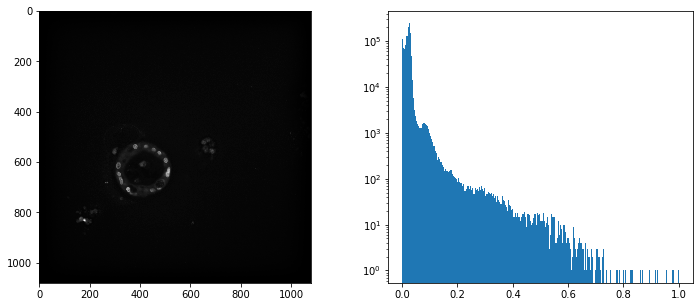

In [3]:
image = img_as_float(imread("../samples/organo.tiff"))
image = apodise(image, 60)
image /= image.max()
nx, ny = image.shape
fig, (ax_im, ax_hist) = plt.subplots(1, 2)
ax_im.imshow(image, cmap='Greys_r')
h = ax_hist.hist(image.ravel(), bins=256)
_ = ax_hist.set_yscale('log')
fig.set_size_inches(12, 5)

# Generalized Maximum Likelyhood evaluation of the PSF

In [4]:
modes = [] #[(2, -2), (2, 2), (4, 0)]
initial_guess = {
    "alpha": 2,
    "beta": 1.0e-3,
    "resolution": 6.0,
}
initial_guess.update({mode:1e-4 for mode in modes})
res, params = estimate_psf(
    image,
    modes=modes,
    initial_guess=initial_guess,
    fit_resolution=True,
    method="Nelder-Mead",
    options={"xtol": 1e-8},
)
print_params(params)

/home/guillaume/Dev/auto_metro/auto_metro/myopic_deconv.py:27: RuntimeWarning: invalid value encountered in true_divide
  return W / W.sum()
/home/guillaume/Dev/auto_metro/auto_metro/myopic_deconv.py:106: RuntimeWarning: invalid value encountered in greater
  denom = np.exp(np.sum(np.log(w[w > 0])) / w.size)


α : -2.000e+00
β : 1.000e-03
resolution : 6.000e+00


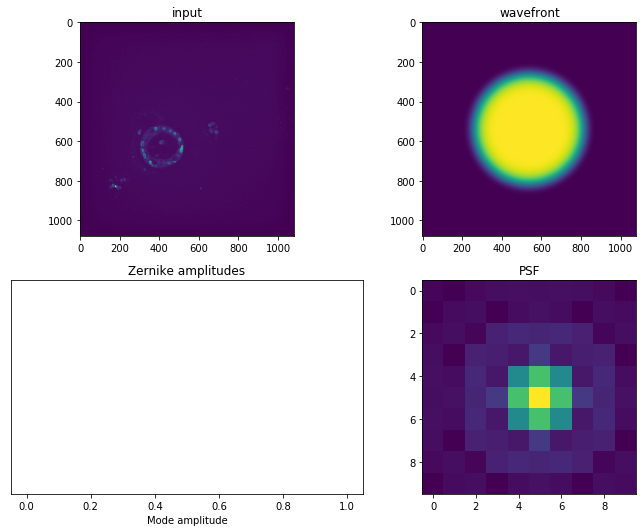

In [5]:
fig, axes = show_results(image, params, modes, fft_window=5)


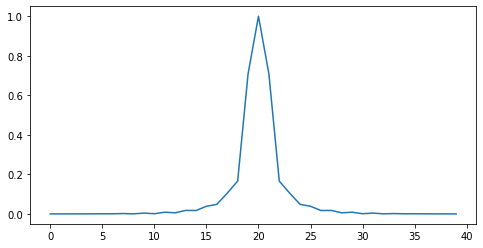

In [10]:
tf = get_tf(nx, ny, params, modes)
fig, ax = plt.subplots()
ax.plot(np.abs(_fft(tf)[nx//2, ny//2-20:ny//2+20]))
#ax.set_yscale('log')
fig.set_size_inches(8, 4)


### Same data rotated by 90°

In [11]:
modes = [(2, -2), (2, 2), (4, 0)]
params_T = estimate_psf(
    image.swapaxes(0, 1),
    modes=modes,
    initial_guess=params,
    fit_resolution=False,
    method="Nelder-Mead",
    options={"xtol": 1e-8},
)

print_params(params_T)


α : -1.379e+01
β : -8.208e-10
resolution : 6.000e+00
Oblique astigmatism:  3.578e-03
Vertical astigmatism: -4.580e-02
Primary Spherical:  1.627e+00


### Comparing the image and it's rotation by 90°

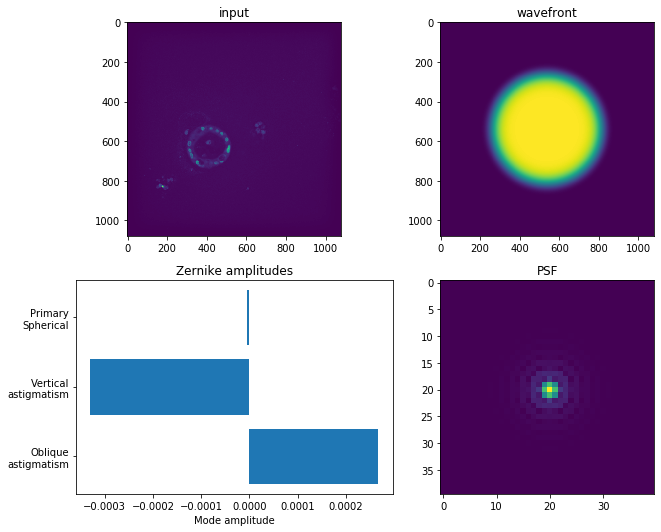

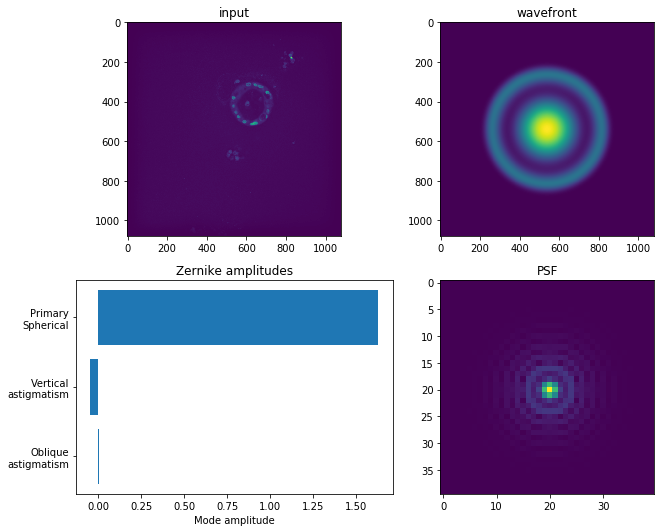

In [12]:
fig, axes = show_results(image, params, modes)
fig, axes = show_results(image.T, params_T, modes)

## Introducing strong astigmatism

Optimisation Input


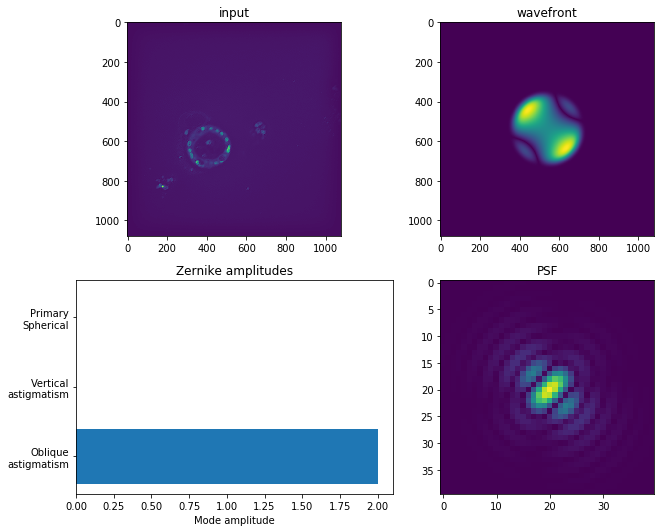

In [13]:
nx, ny = image.shape
xx, yy = np.meshgrid(np.linspace(-1, 1, ny), np.linspace(-1, 1, nx))
rho = (xx ** 2 + yy ** 2) ** 0.5
phi = np.arctan2(yy, xx)

tf_astigmatic = zernike_tf(rho, phi, 10., [1.0, 2.0, 0.0, 0.0], [(0, 0)] + modes)
in_params = {
    "alpha": 1.,
    "beta": 2.,
    "resolution": 10.,
    (2, -2): 2.0,
    (2, 2): 0.0,
    (4, 0): 0.0,
}
im_fft = _fft(image)
#im_fft /= np.abs(im_fft).sum()
image_astigm = np.real(_ifft(im_fft * tf_astigmatic))

print("Optimisation Input")
fig, axes = show_results(image_astigm, in_params, modes)

In [14]:
params_as = estimate_psf(
    image_astigm,
    modes=modes,
    initial_guess={
        "alpha": 1.,
        "beta": 2.,
        "resolution": 10.,
    },
    fit_resolution=False,
    method="Nelder-Mead",
    options={"xtol": 1e-8},
)

/home/guillaume/Dev/auto_metro/auto_metro/myopic_deconv.py:102: RuntimeWarning: invalid value encountered in true_divide
  w = prior / (mtf2 + prior)
/home/guillaume/Dev/auto_metro/auto_metro/myopic_deconv.py:104: RuntimeWarning: invalid value encountered in greater
  denom = np.exp(np.sum(np.log(w[w > 0])) / w.size)


Optimisation output
α : -4.165e+01
β : 5.388e-13
resolution : 1.000e+01
Oblique astigmatism: -1.046e-06
Vertical astigmatism: -1.621e-06
Primary Spherical:  2.732e-05


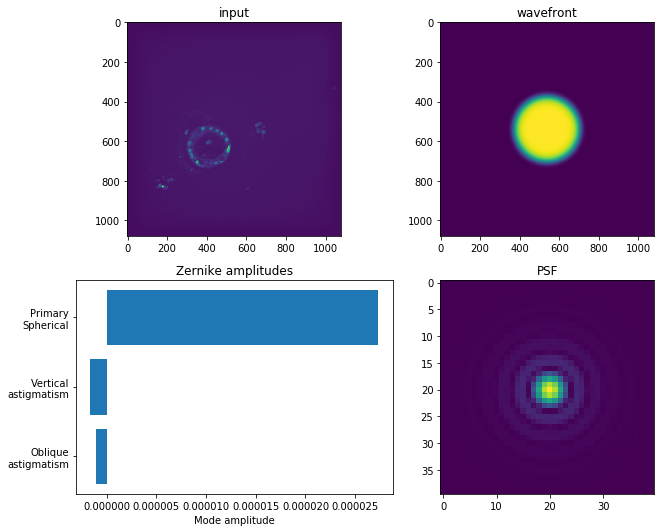

In [15]:
print('Optimisation output')
print_params(params_as)
fig, axes = show_results(image_astigm, params_as, modes)

### 90° rotation

In [16]:
params_asr = estimate_psf(
    image_astigm.swapaxes(0, 1),
    modes=modes,
    initial_guess={
        "alpha": 1.,
        "beta": 2.,
        "resolution": 10.,
    },
    fit_resolution=False,
    method="Nelder-Mead",
    options={"xtol": 1e-8},
)


α : -4.165e+01
β : 3.535e-14
resolution : 1.000e+01
Oblique astigmatism: -7.097e-06
Vertical astigmatism: -2.561e-06
Primary Spherical:  2.994e-05


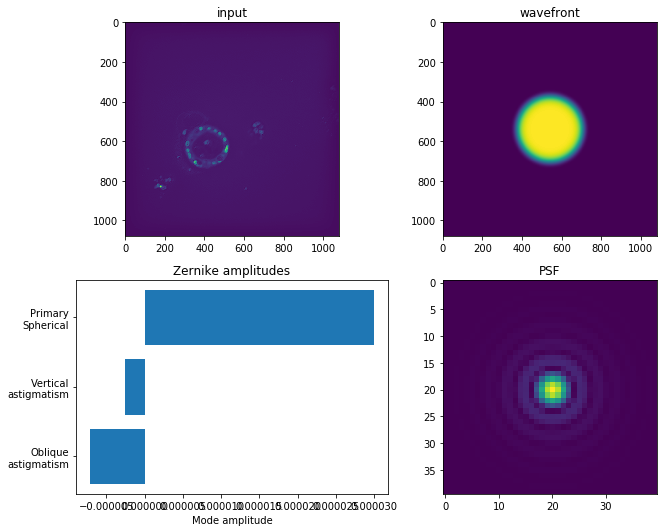

In [17]:
print_params(params_asr)
fig, axes = show_results(image_astigm, params_asr, modes)